# **Neural Networks & Deep Learning: Applied Deep Learning**
Daimler Garay


***
### **Data:**
*The dataset contain  7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. The dataset is available on Brain Tumor MRI Dataset | Kaggle and is created by MASOUD NICKPARVAR. It is a combination of three separated datasets figshare | authored by Jun Cheng, Brain Tumor Classification (MRI) | authored by SARTAJ and Br35H | authored by AHMED HAMADA.*

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
***

# **Abstract**
***

This notebook is created with the aim of assisting hospitals create a system in which it can determine whether a patient has a tumor or not, as well as telling us what kind of tumor it is. This notebook creates a neural network which is able to classify brain MRI images which are compromised of glioma, meningioma, pituitary and no tumor. As the data is compromised of different datasets, the images are not all the same shape and size, therefore I had to rectify this to ensure that our model works. I also applied some augmentation to the image to ensure that our model has some variety, which will assist our models learning - hence why my model uses a CNN. I had one model which produced an accurcy of 99% training, 98% validation and 98% testing, which are all accompanied by ~<0.09 loss. The model was able to correctly predit 21 out of 21 images. The model can still be improved by tampering with optimizer and adjusting learning rates, however the results given are satisfactory enough. 

# **Preprocessing**
***

In [89]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import os

IMPORTING DATA

# **NOTES ON FILE MODS**

In [90]:
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

def importing_data(file, shuffle = True, random_state = 7):
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    X = []
    y = []
    
    for label in os.listdir(file):
        label_dir = os.path.join(file, label)

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            X.append(image_path)
            y.append(label)
            
    if shuffle:
        X, y = shuffle(X, y, random_state=random_state)
            
    return X, y

In [91]:
train_dir = './N_TRAINING/'
test_dir = './N_TESTING/'
val_dir = './N_VALIDATION/'

X_train, y_train = importing_data(train_dir)
X_test, y_test = importing_data(test_dir)
X_valid, y_valid = importing_data(val_dir)

print('Training')
print(f'Number of Paths: {len(X_train)}')
print(f'Number of Labels: {len(y_train)}')
print('\nTesting')
print(f'Number of Paths: {len(X_test)}')
print(f'Number of Labels: {len(y_test)}')
print('\nValidation')
print(f'Number of Paths: {len(X_valid)}')
print(f'Number of Labels: {len(y_valid)}')

Training
Number of Paths: 5619
Number of Labels: 5619

Testing
Number of Paths: 701
Number of Labels: 701

Validation
Number of Paths: 703
Number of Labels: 703


DISTRIBUTIONS

In [92]:
counts = [len([x for x in y_train if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(counts)

Training Counts
[1406, 1600, 1316, 1297]


In [93]:
test_counts = [len([x for x in y_test if x == label]) for label in CLASS_TYPES]
print('Testing Counts')
print(test_counts)

Testing Counts
[175, 200, 164, 162]


In [94]:
valid_counts = [len([x for x in y_valid if x == label]) for label in CLASS_TYPES]
print('Valid Counts')
print(valid_counts)

Valid Counts
[176, 200, 165, 162]


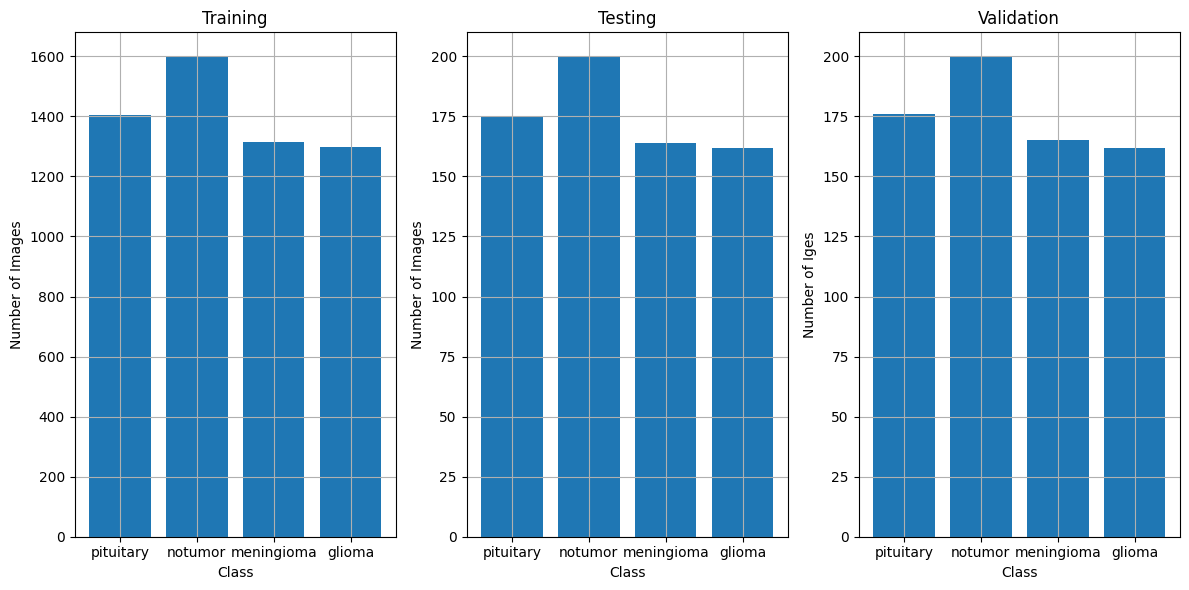

In [95]:
# creating a plot for the distributions
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

total = np.unique(counts, return_counts=True)
total = np.arange(len(CLASS_TYPES))
axes[0].bar(total, counts, tick_label=CLASS_TYPES)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training')
axes[0].grid()

test_total = np.unique(test_counts, return_counts=True)
test_total = np.arange(len(CLASS_TYPES))
axes[1].bar(test_total, test_counts, tick_label=CLASS_TYPES)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Testing')
axes[1].grid()

valid_total = np.unique(valid_counts, return_counts=True)
valid_total = np.arange(len(CLASS_TYPES))
axes[2].bar(valid_total, valid_counts, tick_label=CLASS_TYPES)
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Number of Iges')
axes[2].set_title('Validation')
axes[2].grid()


plt.tight_layout()
plt.show()

For both the training and testing set, it seems there is slightly more 'No Tumor' images when compared to the rest of the images. However, the difference isnt overbearing.

x reshaped: (1, 150, 150, 3)


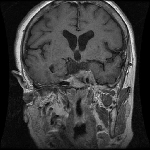

In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

# getting image to test output
img = load_img(X_train[32], target_size=(150, 150))
img = img_to_array(img)

# reshape it to (1, 150, 150, 3)
img = np.expand_dims(img, axis=0)
print(f'x reshaped: {img.shape}')

# normilzation tensor
img /= 255.0

# Convert the array back to the image format
img = array_to_img(img[0])
img

In [97]:
# taking the code above and forming a function which returns images based on a list of indices
def image_display(index, image_data, label_data, target_size=(150, 150)):

    num_images = len(index)
    num_cols = 3 
    num_rows = (num_images // num_cols) + (num_images % num_cols > 0)  # calculate number of rows

    fig, ax = plt.subplots(num_rows, num_cols, figsize = (10, 10))

    for i, ix in enumerate(index):
        # load and prepare the image
        img = load_img(image_data[ix], target_size=target_size)
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img /= 255.0

        # convert the array back to the image format
        img = array_to_img(img[0])

        # Display the image with label
        row = i // num_cols
        col = i % num_cols
        ax[row, col].imshow(img)
        ax[row, col].axis('off')
        ax[row, col].set_title(f"Label: {label_data[ix]}")
            

    plt.tight_layout()
    plt.show()

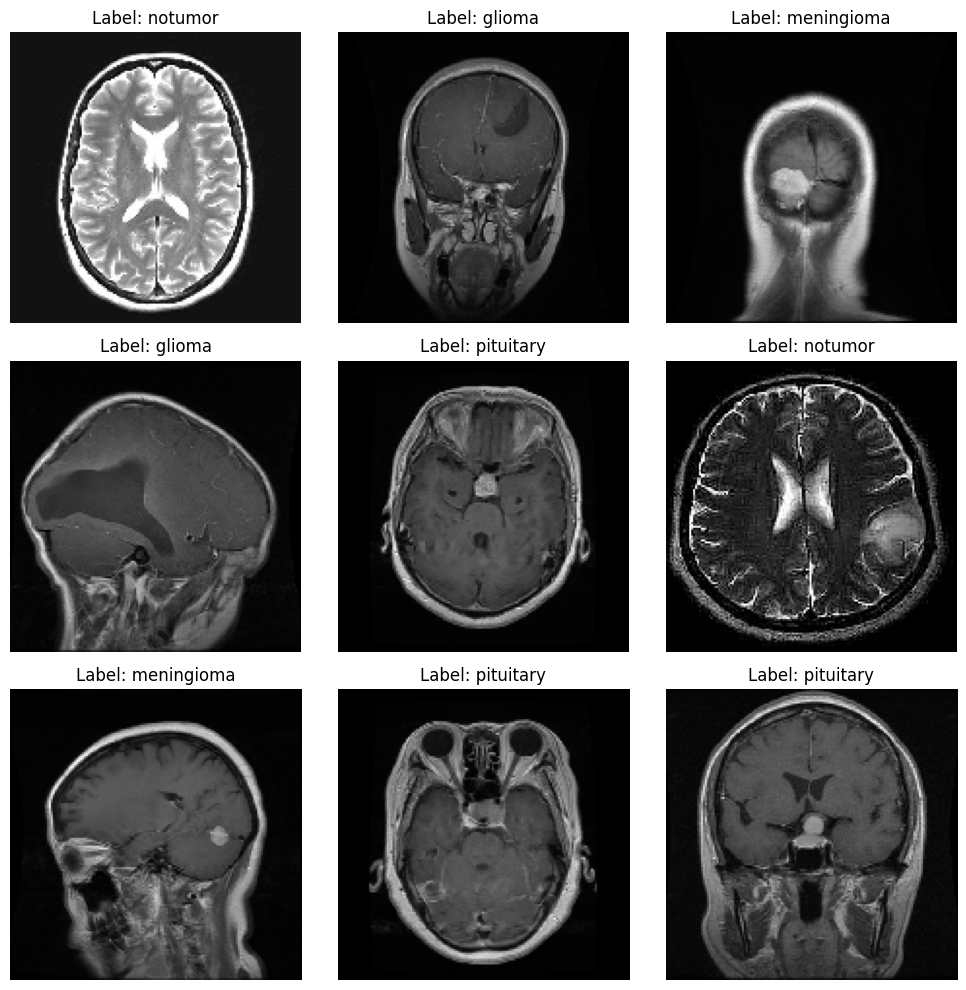

In [98]:
# testing function
image_display([20, 10, 15, 16, 35, 70, 102, 201, 3002], X_train, y_train)

AUGMENTING

In [99]:
# importing libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up data augmentation

image_size = (150, 150)
batch_size = 64

train_dgen = ImageDataGenerator(rescale=1./255,
                                rotation_range = 10,
                                width_shift_range = 0.002,
                                height_shift_range = 0.002,
                                shear_range = 12.5,
                                horizontal_flip = True,
                                vertical_flip = False,
                                fill_mode = 'nearest')

train_gen = train_dgen.flow_from_directory(train_dir,
                                           target_size = image_size,
                                           batch_size = batch_size,
                                           class_mode = 'categorical')

valid_dgen = ImageDataGenerator(rescale = 1./255)

valid_gen = valid_dgen.flow_from_directory(val_dir,
                                         target_size = image_size,
                                         batch_size =  batch_size,
                                         class_mode = 'categorical',
                                         shuffle = False)

test_dgen = ImageDataGenerator(rescale = 1./255)

test_gen = test_dgen.flow_from_directory(test_dir,
                                         target_size = image_size,
                                         batch_size =  batch_size,
                                         class_mode = 'categorical',
                                         shuffle = False)
                        


Found 5619 images belonging to 4 classes.
Found 703 images belonging to 4 classes.
Found 701 images belonging to 4 classes.


# **MODELS**
***

In [100]:
# importing librabries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Conv2D, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [101]:
# setting up global values

image_shape = (image_size[0], image_size[1], 3)

epochs = 50

steps_per_epoch = train_gen.samples // batch_size

validation_steps = valid_gen.samples // batch_size

testing_steps = test_gen.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation Steps Per Epoch: {validation_steps}')
print(f'Testing Steps Per Epoch: {testing_steps}')

Image shape: (150, 150, 3)
Epochs: 50
Batch size: 64
Steps Per Epoch: 87
Validation Steps Per Epoch: 10
Testing Steps Per Epoch: 10


FIRST MODEL

In [102]:
def model_one(img_shape, num_classes):

    model = Sequential()

    # conv 1
    model.add(Conv2D(32, (4, 4), activation="relu", input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(64, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(Flatten())

    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    return model

In [103]:
mod_one = model_one(image_shape, N_TYPES)

mod_one.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 4, 4, 128)        

In [104]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate = 0.001)

mod_one.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= ['accuracy'])

history_one =  mod_one.fit(train_gen, steps_per_epoch = steps_per_epoch, validation_data = valid_gen,
                           epochs = epochs,
                           callbacks = EarlyStopping(monitor = 'loss', patience = 10))

Epoch 1/50
87/87 [==============================] - 62s 705ms/step - loss: 0.8928 - accuracy: 0.5982 - val_loss: 0.6620 - val_accuracy: 0.7440
Epoch 2/50
87/87 [==============================] - 49s 567ms/step - loss: 0.5447 - accuracy: 0.7827 - val_loss: 0.5070 - val_accuracy: 0.8023
Epoch 3/50
87/87 [==============================] - 50s 572ms/step - loss: 0.4851 - accuracy: 0.7964 - val_loss: 0.4433 - val_accuracy: 0.8193
Epoch 4/50
87/87 [==============================] - 50s 578ms/step - loss: 0.4139 - accuracy: 0.8306 - val_loss: 0.3842 - val_accuracy: 0.8592
Epoch 5/50
87/87 [==============================] - 54s 622ms/step - loss: 0.3263 - accuracy: 0.8713 - val_loss: 0.3070 - val_accuracy: 0.8791
Epoch 6/50
87/87 [==============================] - 55s 633ms/step - loss: 0.2795 - accuracy: 0.8904 - val_loss: 0.3005 - val_accuracy: 0.9075
Epoch 7/50
87/87 [==============================] - 65s 751ms/step - loss: 0.2184 - accuracy: 0.9174 - val_loss: 0.2817 - val_accuracy: 0.9018

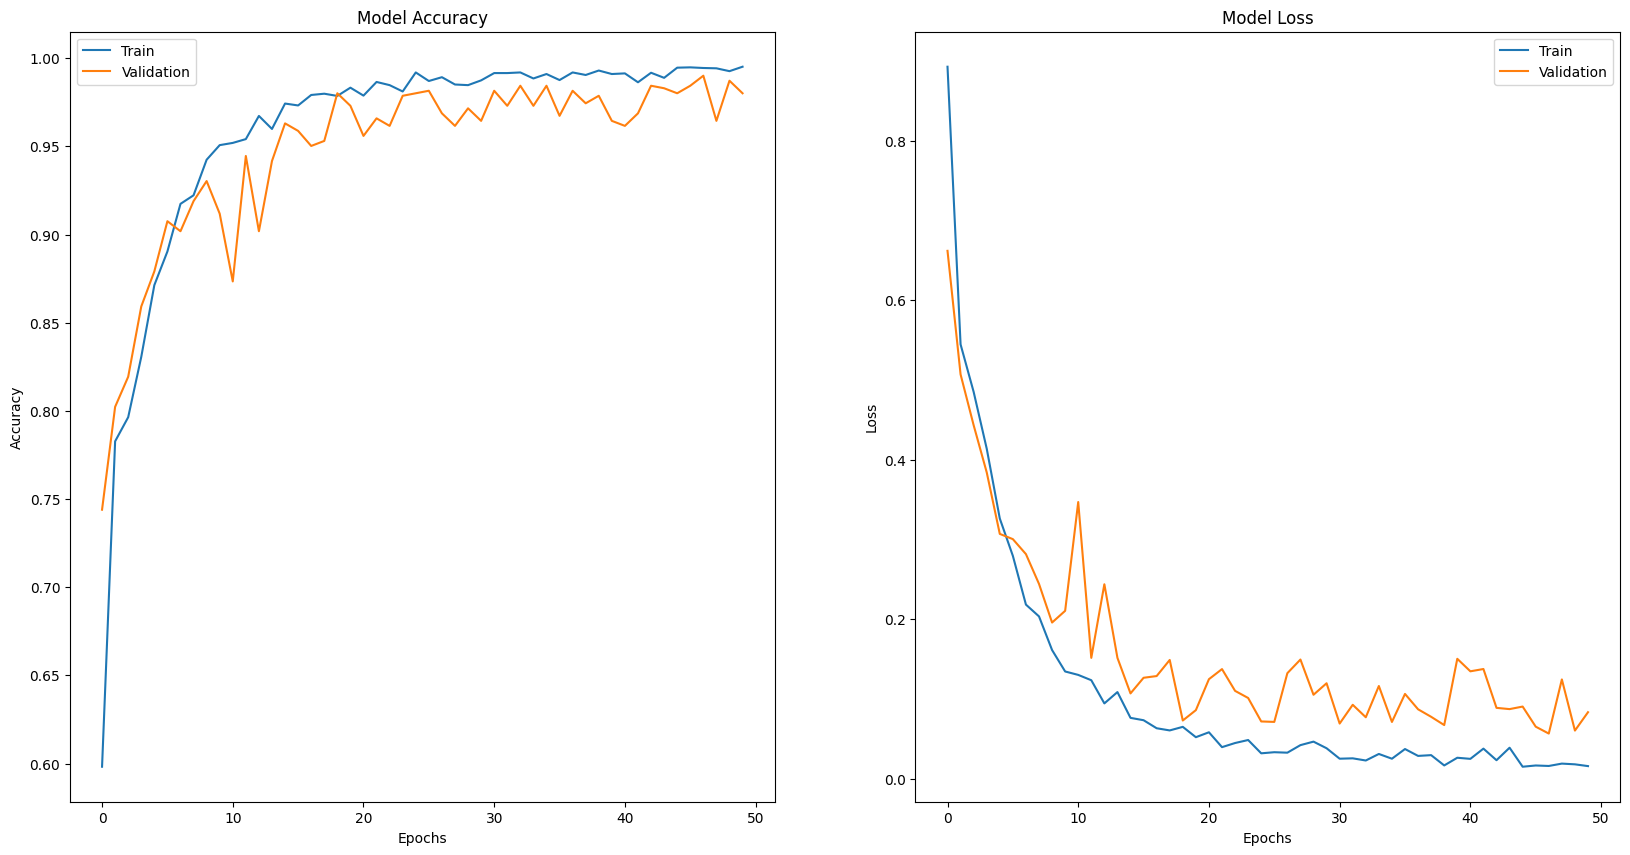

In [105]:
_, ax = plt.subplots(ncols = 2, figsize = (20, 10))

ax[0].plot(history_one.history['accuracy'])
ax[0].plot(history_one.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# plotting out the loss
ax[1].plot(history_one.history['loss'])
ax[1].plot(history_one.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])


plt.show()

SECOND MODEL

In [106]:
def model_two(img_shape, num_classes):

    model = Sequential()

    # conv 1
    model.add(Conv2D(64, (4, 4), activation="relu", input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(256, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(256, (4, 4), activation="relu"))
    model.add(Flatten())

    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation="softmax"))

    return model

In [107]:
mod_two = model_two(image_shape, N_TYPES)

mod_two.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 147, 147, 64)      3136      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 49, 49, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 128)       131200    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 15, 15, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 256)       524544    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 4, 4, 256)        

In [108]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(learning_rate = 0.001)

mod_two.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= ['accuracy'])

history_two =  mod_two.fit(train_gen, steps_per_epoch = steps_per_epoch, validation_data = valid_gen,
                           epochs = epochs,
                           callbacks = EarlyStopping(monitor = 'loss', patience = 10))

Epoch 1/50
87/87 [==============================] - 115s 1s/step - loss: 1.3834 - accuracy: 0.2621 - val_loss: 1.3785 - val_accuracy: 0.2845
Epoch 2/50
87/87 [==============================] - 112s 1s/step - loss: 1.3747 - accuracy: 0.2810 - val_loss: 1.3713 - val_accuracy: 0.2845
Epoch 3/50
87/87 [==============================] - 113s 1s/step - loss: 1.3692 - accuracy: 0.2839 - val_loss: 1.3661 - val_accuracy: 0.2845
Epoch 4/50
87/87 [==============================] - 117s 1s/step - loss: 1.3641 - accuracy: 0.2841 - val_loss: 1.3619 - val_accuracy: 0.2845
Epoch 5/50
87/87 [==============================] - 113s 1s/step - loss: 1.3601 - accuracy: 0.2850 - val_loss: 1.3582 - val_accuracy: 0.2845
Epoch 6/50
87/87 [==============================] - 113s 1s/step - loss: 1.3565 - accuracy: 0.2853 - val_loss: 1.3546 - val_accuracy: 0.2845
Epoch 7/50
87/87 [==============================] - 112s 1s/step - loss: 1.3525 - accuracy: 0.2853 - val_loss: 1.3510 - val_accuracy: 0.2845
Epoch 8/50
87

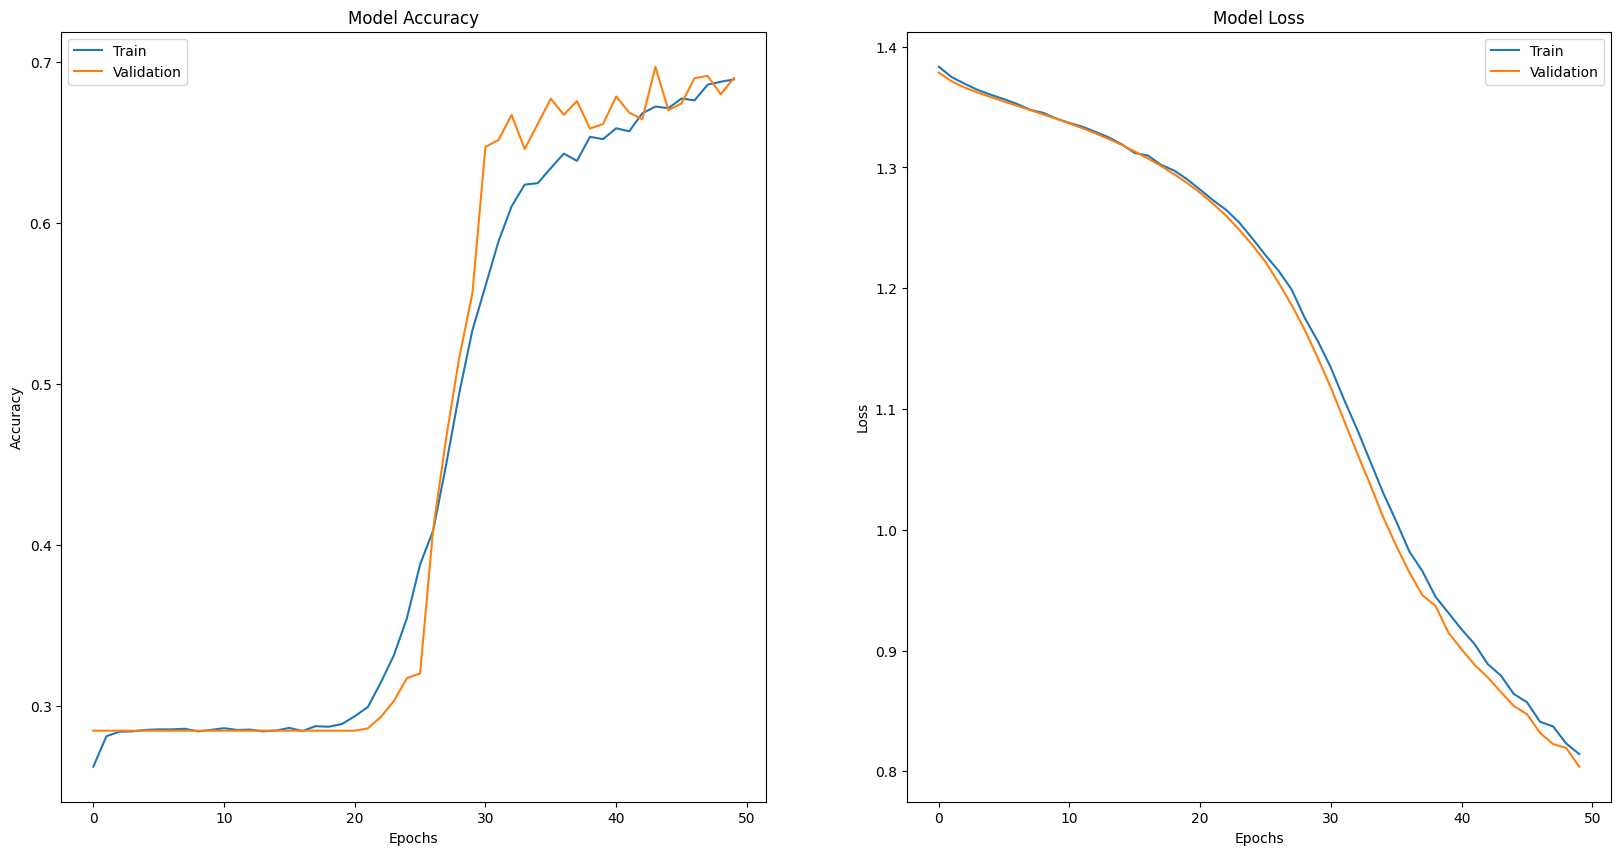

In [109]:
_, ax = plt.subplots(ncols = 2, figsize = (20, 10))

ax[0].plot(history_two.history['accuracy'])
ax[0].plot(history_two.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# plotting out the loss
ax[1].plot(history_two.history['loss'])
ax[1].plot(history_two.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])


plt.show()

THIRD MODEL

In [110]:
def model_three(img_shape, num_classes):

    model = Sequential()

    # conv 1
    model.add(Conv2D(32, (4, 4), activation="relu", input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(64, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(Flatten())

    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    return model

In [111]:
mod_three = model_three(image_shape, N_TYPES)

mod_three.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 128)       131200    
                                                                 
 flatten_5 (Flatten)         (None, 18432)            

In [112]:
optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

mod_three.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics= ['accuracy'])

history_three =  mod_three.fit(train_gen, steps_per_epoch = steps_per_epoch, validation_data = valid_gen,
                           epochs = epochs,
                           callbacks = EarlyStopping(monitor = 'loss', patience = 10))

Epoch 1/50
87/87 [==============================] - 63s 716ms/step - loss: 0.8639 - accuracy: 0.6346 - val_loss: 0.8129 - val_accuracy: 0.6728
Epoch 2/50
87/87 [==============================] - 62s 711ms/step - loss: 0.5161 - accuracy: 0.7933 - val_loss: 0.4702 - val_accuracy: 0.8179
Epoch 3/50
87/87 [==============================] - 61s 698ms/step - loss: 0.4187 - accuracy: 0.8313 - val_loss: 0.4418 - val_accuracy: 0.8151
Epoch 4/50
87/87 [==============================] - 62s 710ms/step - loss: 0.3516 - accuracy: 0.8628 - val_loss: 0.5296 - val_accuracy: 0.8094
Epoch 5/50
87/87 [==============================] - 62s 715ms/step - loss: 0.2917 - accuracy: 0.8864 - val_loss: 0.3239 - val_accuracy: 0.8720
Epoch 6/50
87/87 [==============================] - 64s 740ms/step - loss: 0.2495 - accuracy: 0.9053 - val_loss: 0.2588 - val_accuracy: 0.9147
Epoch 7/50
87/87 [==============================] - 61s 702ms/step - loss: 0.2141 - accuracy: 0.9143 - val_loss: 0.2367 - val_accuracy: 0.9118

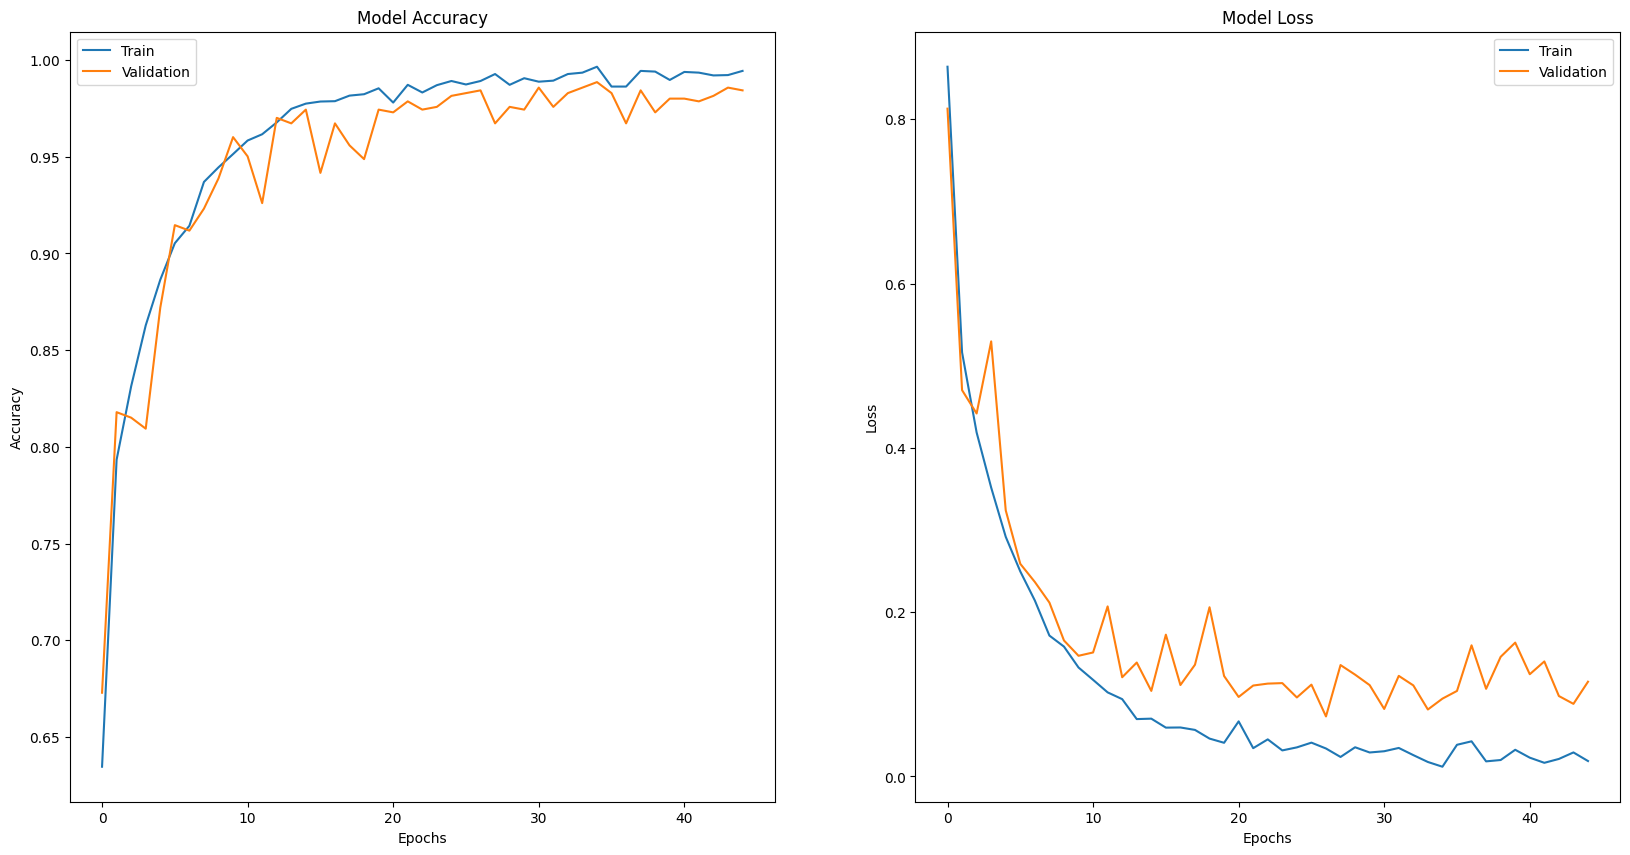

In [113]:
_, ax = plt.subplots(ncols = 2, figsize = (20, 10))

ax[0].plot(history_three.history['accuracy'])
ax[0].plot(history_three.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])

# plotting out the loss
ax[1].plot(history_three.history['loss'])
ax[1].plot(history_three.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])


plt.show()

# **DISCUSSION**
***

COMPARISONS


| MODEL            | TRAINING | VALIDATION                                       |
|---------------------------|--------------------------|--------------------------|
| MODEL ONE                  | 99.51% | 98.01%   |
| MODEL TWO       | 68.91%  |68.99  |
| MODEL THREE              | 99.44%  |  98.44% |


From this table, we can see based on accuracy that our best model is either model one or model three by a close margin. To determine which of the two is better we'll print a comparison of each model's loss.

Also, its a good sign that none of the models are overfitting or underfittng. Model two just has abysmally low accuracy possibly due to the high amounts of neurons its using.

In [127]:
loss, accs = mod_one.evaluate(valid_gen, steps = testing_steps)

print(f'The Loss is: {loss:0.5f}')

10/10 [==============================] - 2s 152ms/step - loss: 0.0912 - accuracy: 0.9781
The Loss is: 0.09122


In [128]:
loss, accs = mod_three.evaluate(valid_gen, steps = testing_steps)

print(f'The Loss is: {loss:0.5f}')

10/10 [==============================] - 2s 148ms/step - loss: 0.1154 - accuracy: 0.9844
The Loss is: 0.11537


We can see that our model one has slightly lower loss which makes it better SLIGHTLY better than model three.


# **TESTING**
***

EVALUATION


In [114]:
loss, accs = mod_one.evaluate(test_gen, steps = testing_steps)

print(f'The Loss is: {loss:0.5f}')
print(f'Test Accuracy is: {accs:0.5f}')

10/10 [==============================] - 2s 243ms/step - loss: 0.0785 - accuracy: 0.9812
The Loss is: 0.07846
Test Accuracy is: 0.98125


In [115]:
train_sc = mod_one.evaluate(train_gen, steps = steps_per_epoch, verbose = 0)
valid_sc = mod_one.evaluate(valid_gen, steps = validation_steps, verbose = 0)
test_sc =mod_one.evaluate(test_gen, steps = testing_steps, verbose = 0)


print('Train Scores : \n    accuracy:', train_sc[1], '\n      Loss: ', train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', valid_sc[1], '\n      Loss: ', valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', test_sc[1], '\n      Loss: ', test_sc[0], '\n________________________')

Train Scores : 
    accuracy: 0.9931752681732178 
      Loss:  0.01571575738489628 
________________________
Valid Scores : 
    accuracy: 0.9781249761581421 
      Loss:  0.0912175327539444 
________________________
Test Scores : 
    accuracy: 0.981249988079071 
      Loss:  0.07846474647521973 
________________________


From these accuracies, we can see that our model is performing really well. All three accuracies are high and have low losses.

PREDICTIONS

In [116]:
preds = mod_one.predict(test_gen)
y_preds = np.argmax(preds, axis = 1)

print(preds)
print(y_preds)

11/11 [==============================] - 2s 178ms/step
[[1.00000000e+00 1.05516616e-10 7.79831755e-10 5.07292013e-15]
 [1.00000000e+00 1.74087980e-10 4.07296851e-17 5.67277321e-18]
 [9.99992490e-01 7.05483626e-06 3.67949269e-07 9.37750286e-08]
 ...
 [2.31715944e-06 2.48245022e-04 1.86189427e-05 9.99730766e-01]
 [5.46264631e-11 7.07097669e-09 5.04483069e-08 1.00000000e+00]
 [6.46822318e-11 1.07452651e-08 1.40415232e-11 1.00000000e+00]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [117]:
# creating a function that can visualize model prediction

def visualize_preds(mods, generator, cats, dirs, samples = 6, figsize = (15, 10)):
    
    preds = mod_one.predict(generator)
    preds = np.argmax(preds, axis = 1)
    true_labels = generator.classes

    # implementing images
    images = np.array(generator.filepaths)
    index = np.random.choice(len(images), size = samples, replace= False)
    s_images = images[index]
    s_preds = [cats[preds[i]] for i in index]
    s_tpreds = [cats[true_labels[i]] for i in index]

    plt.figure(figsize = figsize)

    # creating a loop

    for i, path in enumerate(s_images):
        plt.subplot(7, 3, i + 1)
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')

        # assigning a color for correct or incorrect predictions
        prediction_color = 'green' if s_preds[i] == s_tpreds[i] else 'red'
        plt.title(f"Predicted: {s_preds[i]}\nTrue: {s_tpreds[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()                


11/11 [==============================] - 2s 178ms/step


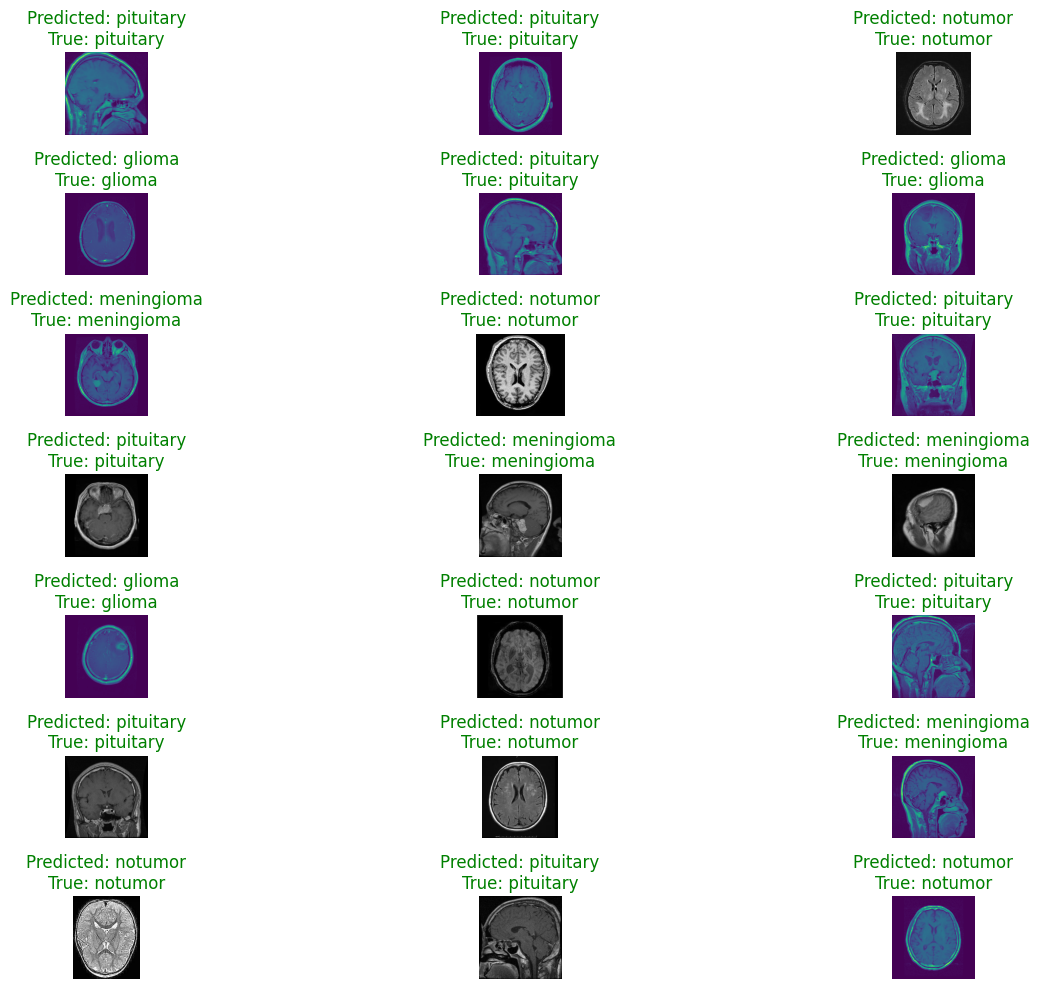

In [118]:
class_indices_train = train_gen.class_indices
class_indices_train_list = list(train_gen.class_indices.keys())

visualize_preds(mods = mod_one, 
                generator = test_gen,
                cats = class_indices_train_list,
                dirs = test_dir,
                samples = 21,
                figsize = (15, 10))

As we can see the model predictions are 100% correct for this instance. The model predicted 21 out of 21 images correctly.

METRICS

In [119]:
from sklearn.metrics import classification_report, confusion_matrix

test_index = test_gen.class_indices
test_classes = list(test_index.keys())

mats = confusion_matrix(test_gen.classes, y_preds)
mats

array([[154,   8,   0,   0],
       [  0, 164,   0,   0],
       [  0,   1, 199,   0],
       [  1,   3,   0, 171]], dtype=int64)

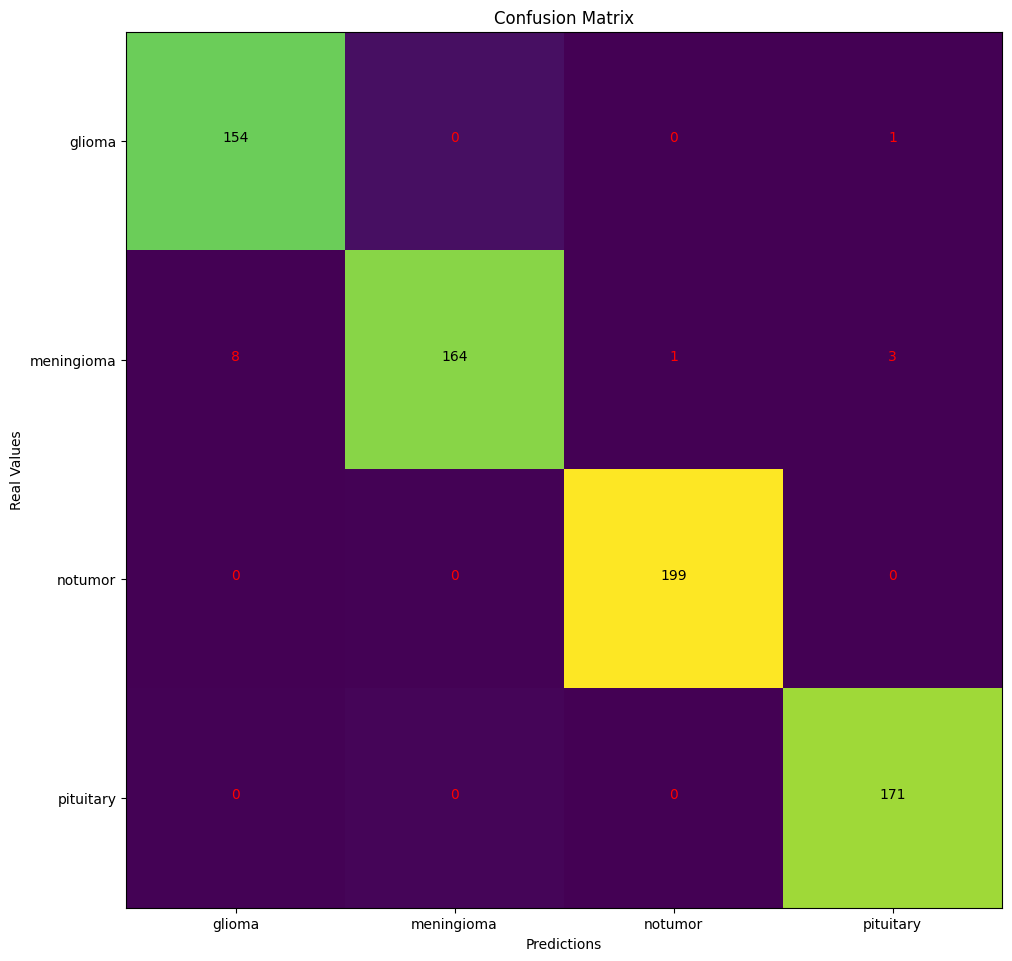

In [120]:
plt.figure(figsize = (10, 10))
plt.imshow(mats)
plt.title('Confusion Matrix')


tick_marks = np.arange(len(test_classes))
plt.xticks(tick_marks, test_classes)
plt.yticks(tick_marks, test_classes)

import itertools
thresh = mats.max()/2
for i, j in itertools.product(range(mats.shape[0]), range(mats.shape[1])):
    plt.text(i, j, mats[i, j], horizontalalignment = 'center', color = 'black' if mats[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

This confusion matrix is basically a testament to how good our model is performing, as nearly all images are classified correctly.

In [121]:
# classification report

print(classification_report(test_gen.classes, y_preds, target_names = test_classes))

              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       162
  meningioma       0.93      1.00      0.96       164
     notumor       1.00      0.99      1.00       200
   pituitary       1.00      0.98      0.99       175

    accuracy                           0.98       701
   macro avg       0.98      0.98      0.98       701
weighted avg       0.98      0.98      0.98       701



# **CONCLUSION**
***

Out of the three models, that we created it came down to a choice between either model one or model three. In the end we chose model one simply because it had a slighly lower loss. Overall this model performed well beyond what I could have expected. The only way I think this model could be improved is by adjusting the values for the optimizer, specifically the learning rates. However, that would take some trial and error which isn't exactly a task even the most invigorated would do. 

Nonetheless, I still believe that the model could be improved further, but it is currently at a stage which I am satisfied with hence why I will stop here.


11/11 [==============================] - 4s 388ms/step


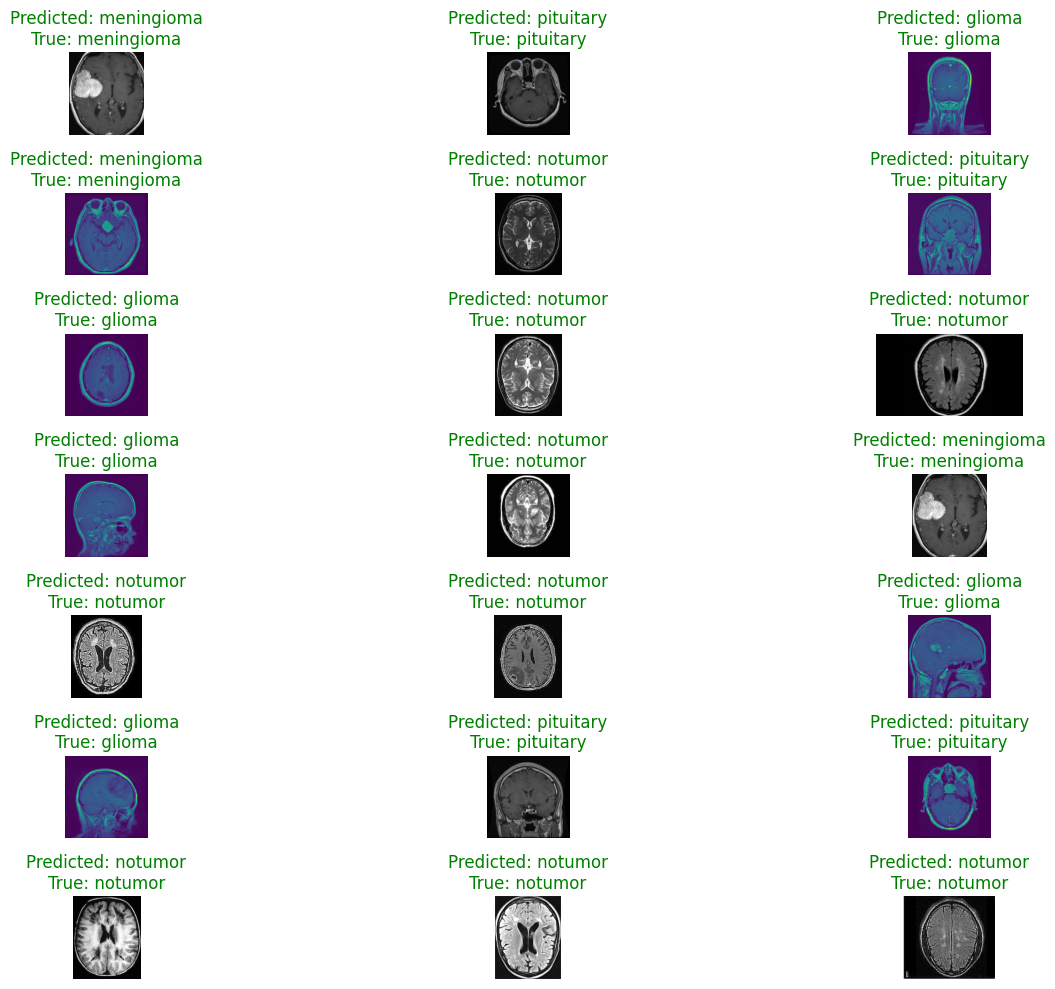

In [132]:
# showing predictions again

visualize_preds(mods = mod_one, 
                generator = test_gen,
                cats = class_indices_train_list,
                dirs = test_dir,
                samples = 21,
                figsize = (15, 10))